In the past two posts, we showed how to use Nitsche's method for the Poisson equation and for the Stokes equations.
In the latter case Nitsche's method makes it possible to implement a boundary condition that cannot be enforced in the conventional way.
I got interested in all of this as a way to attack a particular problem in glacer flow.
Stokes flow is a sound physical model for predicting the velocity of glaciers, but for ice the stress tensor is a *power law* function of the strain rate tensor:

$$\tau = B|\dot\varepsilon|^{\frac{1}{n} - 1}\dot\varepsilon$$

This begs the question of how to extend Nitsche's method for nonlinear PDE.
I don't know how to do this and I couldn't find any published papers that had, so here are my attempts.

Rather than go straight to the Stokes equations, I thought it might be best to try things out on the Laplace equation with a power-law nonlinearity.
For this problem we're only looking for a scalar field and not a vector field, and there's no incompressibility constraint to deal with.
The power-law Laplace problem is to minimize the functional

$$J(u) = \int_\Omega\left(\frac{1}{p}k|\nabla u|^p - fu\right)dx$$

subject to the boundary condition $u|_{\partial\Omega} = g$.
For $p = 2$, this is a quadratic minimization problem and so the Euler-Lagrange equation is linear.
For other values of $p$ the Euler-Lagrange equations are nonlinear.

### The Lagrange multiplier

The first step that we took with Nitsche's method was to compute what the Lagrange multiplier would be if we were to use a constrained optimization-type approach to enforce the boundary conditions.
The Lagrangian is

$$L(u, \lambda) = J(u) + \int_{\partial\Omega}\lambda(u - g)ds.$$

Using the same tricks as before, we find that

$$\lambda = -k|\nabla u|^{p - 2}\frac{\partial u}{\partial n},$$

or in other words the Lagrange multiplier is the flux out of the boundary.

### The Nitsche functional

When we derived Nitsche's method for linear problems, we were able to start with some guess for the boundary penalty term.
The coefficients in the problem provide some physical scales that we were able to use to determine how the penalty would scale.
We could then work out the dimensionless part based on some finite element inverse inequalities.
Underlying this part of the procedure is the understanding that:

1. a function $u$ that solves the Poisson equation will live in the Sobolev space $H^1(\Omega)$, and
2. the boundary values of a function $u$ in $H^1(\Omega)$ live in the space $H^{1/2}(\partial\Omega)$.

The choice of boundary penalty is much less obvious for the p-Laplace equation.
The solution $u$ lives in the Sobolev space $W_1^p(\Omega)$, so the 2-norm of the boundary value discrepancy might be either too restrictive or not restrictive enough depending on whether $p$ is less than or greater than 2.
We'll start out with the fact that, if $u \in W_1^p(\Omega)$, then $u|_{\partial\Omega}$ is in $L^p(\partial\Omega)$.
From this we can see what happens if we try a penalty that looks like:

$$J_{\text{boundary}} = \text{constant} \cdot \int_{\partial\Omega}\text{coefficients}\cdot|u - g|^p ds.$$

But we also need to make the units match up with those of the rest of the Lagrangian, the dimensions of which are

$$[J] = \left[\int_\Omega k|\nabla u|^p dx\right] = [k] \cdot [u]^p \cdot [x]^{d - p}.$$

The factor of $[x]^d$ comes from the measure $dx$, while the factor of $[x]^{-p}$ comes from the gradient of $u$.
Since the surface measure $ds$ has units of $[x]^{d - 1}$, we can take the boundary penalty to be

$$J_{\text{boundary}} = \text{constant}\cdot\int_{\partial\Omega}\frac{k}{ph^{p - 1}}|u - g|^p ds.$$

All together now, a sensible-looking Nitsche functional for the power-law Laplace equation is

$$J_\gamma(u) = J(u) - \int_{\partial\Omega}k|\nabla u|^{p - 2}\frac{\partial u}{\partial n}(u - g)ds + \int_{\partial\Omega}\frac{\gamma k}{ph^{p - 1}}|u - g|^pds.$$

As a sanity check, observe that if $p = 2$ this is exactly equal to the Nitsche functional we derived for linear problems.
You can also view this penalty as an approximation to the [Slobodeckij semi-norm](https://en.wikipedia.org/wiki/Sobolev_space#Sobolev%E2%80%93Slobodeckij_spaces) for functions that live in finite element spaces on meshes.

All we have to do now is (1) prove that it's convex for sufficiently large values of $\gamma$ and (2) determine what "sufficiently large" is.

### The inverse inequality

To find a value of $\gamma$ that made the Nitsche functional convex for linear problems, we used sharp bounds for the constant in the inverse inequality from a [paper](https://www.sciencedirect.com/science/article/pii/S0045782503002949) by Warburton and Hesthaven.
As a reminder, the inverse inequality states that, if $u$ of degree $m$ on a simplex $E$ in dimension $d$ and $Tu$ is the trace of $u$ on the boundary $\partial\Omega$,

$$\|Tu\|_{L^2(\partial\Omega)} \le \left(\frac{(m + 1)(m + d)}{d}\cdot\frac{|\partial E|}{|E|}\right)^{\frac{1}{2}}\|u\|_{L^2(\Omega)}.$$

Warburton and Hesthaven focused on estimates in the 2-norm in their paper.
In this setting, the analytical expression for orthogonal polynomials on the simplex is especially handy.

To prove that the Nitsche functional for the power-law Laplace equation is convex, we'll need a sharp bound on the constant in the inverse inequality for general $p$-norms.
Without the luxury of orthogonal polynomials as in the $p = 2$ case it might seem like we haven't go anywhere to go, but let's just focus on $p = \infty$ for now.
If $u$ is bounded on $\Omega$, then so is its restriction to the boundary, and

$$\|Tu\|_{L^\infty(\partial\Omega)} \le \|u\|_{L^\infty(\Omega)}.$$

Consequently, the operation of taking traces, at least when restricted to degree-$m$ polynomials, is a bounded operator both from $L^2(\Omega) \to L^2(\partial\Omega)$ and from $L^\infty(\Omega) \to L^\infty(\partial\Omega)$.
So we can apply the [Riesz-Thorin theorem](https://en.wikipedia.org/wiki/Riesz%E2%80%93Thorin_theorem).
For any $p$ between 2 and $\infty$, $T$ is well-defined and bounded from $L^p(\Omega)$ to $L^p(\partial\Omega)$, and moreover

$$\|T\|_p \le \|T\|_2^{2/p}\|T\|_\infty^{1 - 2/p} = \left(\frac{(m + 1)(m + d)}{d}\cdot\frac{|\partial E|}{|E|}\right)^{1/p}.$$

Invoking the Riesz-Thorin theorem is a little extreme, but I couldn't find a better way to arrive at the same result.
There's another hitch here in that we've only worked things out for $p$ between 2 and $\infty$ but not between 1 and 2.
There might be some elegant way to work out the sub-critical case too.

### Convexity

Here's where things start to fall apart.
I think the most convenient equivalent definition of convexity for this problem is that

$$\langle dJ_\gamma(u) - dJ_\gamma(v), u - v\rangle \ge 0$$

for all $u$ and $v$.
To verify whether this condition holds or not, we'll need to calculate the derivative of $J_\gamma$:

$$\begin{align}
\langle dJ_\gamma(u), v\rangle & = \int_\Omega\left(k|\nabla u|^{p - 2}\nabla u\cdot\nabla v - fv\right)dx \\
&\quad  - \int_{\partial\Omega}k|\nabla u|^{p - 2}\left\{\left(I + (p - 2)\frac{\nabla u\otimes\nabla u}{|\nabla u|^2}\right)\nabla v\right\}\cdot n\cdot (u - g)\,ds \\
&\qquad - \int_{\partial\Omega}k|\nabla u|^{p - 2}\frac{\partial u}{\partial n}v\, ds + \int_{\partial\Omega}\frac{\gamma k}{h^{p - 1}}|u - g|^{p - 2}(u - g)\cdot v\, ds
\end{align}$$

The boundary integral in the second line makes this much more complex than in the linear case.
So far I haven't succeeded.
If we wanted to instead calculate the second derivative and show that it's positive-definite, we'll have many more terms that need to be majorized and that doesn't look simple.

### Experiment

I can't prove anything yet, but we can conduct an experiment to see whether my guess for a good penalty parameter will work.
First, we'll take $u$, $g$, and $f$ to be random trigonometric polynomials.
We can then calculate the second derivative of the Nitsche functional around $u$ symbolically.
To show that the second derivative is positive-definite, we can calculate its smallest eigenvalue by pulling out the assembled PETSc matrix and calling an eigensolver from the package [SLEPc](http://slepc.upv.es/).
If this eigenvalue is negative then I've messed up somewhere.
On the other hand, if we try this repeatedly and find that the second derivative is positive-definite for many different choices of $u$ and $g$, then we might just be onto something.

First, we'll create the boundary values and right-hand side as random trigonometric polynomials.
I've chosen the number of modes and coefficient decay rate to give interesting-looking but reasonable input data.

In [1]:
import numpy as np
import firedrake

nx, ny = 32, 32
mesh = firedrake.UnitSquareMesh(nx, ny)
degree = 2
Q = firedrake.FunctionSpace(mesh, family='CG', degree=degree)

def random_fourier_series(Q, std_dev, num_modes, exponent):
    mesh = Q.mesh()
    x, y = firedrake.SpatialCoordinate(mesh)

    from firedrake import sin, cos
    from numpy import pi as π
    A = std_dev * np.random.randn(num_modes, num_modes)
    B = std_dev * np.random.randn(num_modes, num_modes)
    expr = sum([(A[k, l] * sin(π * (k * x + l * y)) +
                 B[k, l] * cos(π * (k * x + l * y))) / (1 + (k**2 + l**2)**(exponent/2))
                for k in range(num_modes)
                for l in range(int(np.sqrt(num_modes**2 - k**2)))])
    return firedrake.Function(Q).interpolate(expr)

In [2]:
f = random_fourier_series(Q, std_dev=1.0, num_modes=6, exponent=1)
g = random_fourier_series(Q, std_dev=.25, num_modes=5, exponent=1)

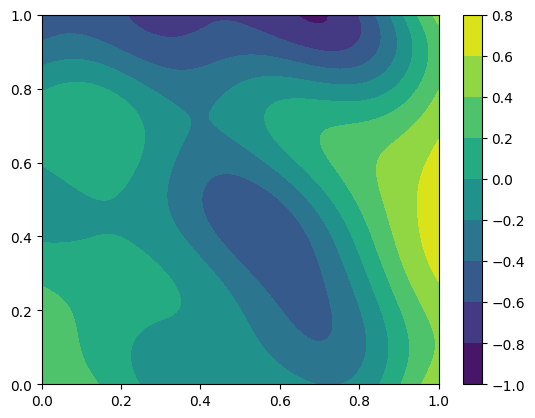

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
contours = firedrake.tricontourf(g, axes=axes)
fig.colorbar(contours);

Next I'll make a random field for $u$, create the action functional for the power-law Laplace equation, and create the right boundary terms for the Nitsche functional.

In [4]:
from firedrake import inner, grad, dx

u = random_fourier_series(Q, std_dev=.25, num_modes=5, exponent=1)

p = firedrake.Constant(3)
J_flexion = 1/p * inner(grad(u), grad(u))**(p/2) * dx
J_force = f * u * dx
J_energy = J_flexion - J_force

In [5]:
from firedrake import ds
n = firedrake.FacetNormal(mesh)
h = firedrake.CellSize(mesh)
σ = -inner(grad(u), grad(u))**((p - 2)/2) * grad(u)

J_flux = inner(σ, n) * (u - g) * ds
J_boundary = 1 / (p * h**(p - 1)) * abs(u - g)**p * ds

Finally we have to calculate a good value for $\gamma$ using the Warburton-Hesthaven bound in the inverse inequality and the calculated minimum angle of the mesh.

In [6]:
from numpy.linalg import norm
coords = mesh.coordinates.dat.data_ro
cells = mesh.coordinates.cell_node_map().values

θ = np.inf
for cell in cells:
    for k in range(3):
        x, y, z = coords[np.roll(cell, k)]
        ζ, ξ = y - x, z - x
        angle = np.arccos(np.inner(ζ, ξ) / (norm(ζ) * norm(ξ)))
        θ = min(angle, θ)
        
α = 1/2
γ = 1/α**2 * 2 * degree * (degree + 1) / np.sin(θ) / np.tan(θ/2)

We can now put everything together to make the Nitsche functional.
Then we can compute the second derivatives of these functional around $u$ symbolically and assemble them into PETSc matrices.

In [7]:
from firedrake import assemble, derivative
F = derivative(J_energy + J_flux + γ * J_boundary, u)
a = derivative(F, u)

ϕ, ψ = firedrake.TestFunction(Q), firedrake.TrialFunction(Q)
m = ϕ * ψ * dx

A = assemble(a).M.handle
M = assemble(m).M.handle

Finally we'll solve an eigenproblem using SLEPc.
The options we pass to SLEPc state that we're solving a generalized Hermitian eigenvalue problem, we're looking for the smallest real eigenvalue, and that we'll shift and invert the matrix to accelerate the solver. 
I'm using GMRES as a Krylov subspace solve rather than conjugate gradients because we're not sure that the matrix is postive definite.

In [8]:
from petsc4py import PETSc
from slepc4py import SLEPc

opts = PETSc.Options()
opts.setValue('eps_gen_hermitian', None)
opts.setValue('eps_target_real', None)
opts.setValue('eps_smallest_real', None)
opts.setValue('st_type', 'sinvert')
opts.setValue('st_ksp_type', 'gmres')
opts.setValue('st_pc-type', 'jacobi')
opts.setValue('eps_tol', 1e-8)

num_values = 1
eigensolver = SLEPc.EPS().create(comm=firedrake.COMM_WORLD)
eigensolver.setDimensions(num_values)
eigensolver.setOperators(A, M)
eigensolver.setFromOptions()
eigensolver.solve()

In [9]:
num_converged = eigensolver.getConverged()
print(num_converged)

2


In [10]:
Vr, Vi = A.getVecs()
λ = eigensolver.getEigenpair(0, Vr, Vi)

And the moment of truth:

In [11]:
print(λ)

57.839573569337304


which is well and truly positive!
In every test I've run so far it seems as if the second derivative of the Nitsche functional is positive-definite.
Of course these tests are run using a few random fields, which is far from exhaustive.
I still need a proof that my proposed value of the penalty parameter is good enough, but for now it's encouraging to know that it might work.